In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stat
import corner
import copy as COPY

%matplotlib nbagg
%matplotlib inline
np.random.seed(1)
plt.style.use('ggplot')

In [2]:
Data = pd.read_csv('example_data.txt',delimiter=' ',names=['x','y','err'])
x_values = Data.x
y_values = Data.y
error = Data.err

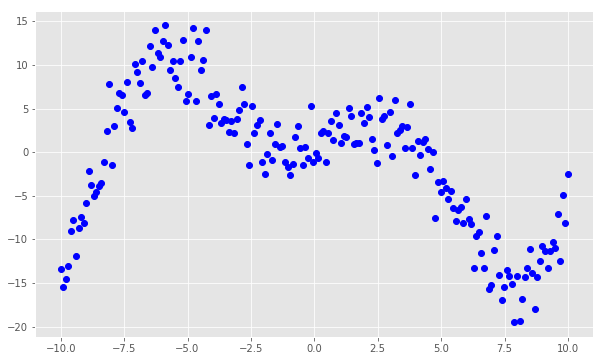

In [3]:
plt.figure(figsize=(10,6))
plt.plot(x_values,y_values,'o',color='blue')

In [5]:
def Model(thetas,x):
    a = thetas[0]
    b = thetas[1]
    c = thetas[2]
    y_i = a*x*np.sin(b*x+c)
    return y_i

def Likelihood(y=None,sigma=None,mu=None):
    term1 = np.log(2*np.pi*(sigma**2))
    term2 = ((y-mu)**2)/(2*sigma**2)
    return sum((term1-term2))

def prior_transform(u = None):
    a = 4.0*u[0]
    b = 3.0*u[1]
    c = 3.1*u[2]
    return np.array([a,b,c])

def propose(u,ndim,scale): #Gaussian proposal  u is the uniform scalling factor [0,1]
    p = u + np.random.uniform(0,scale,size=ndim)
    p[p>1] = 1
    p[p<0] = 0
    
    return p

def plus(x,y):
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [30]:
n = 200  # Number of live points
ndim = 3
objects = np.zeros((n,ndim))
live_objects = np.zeros((n))

for i in range(n):
    objects[i,:] = prior_transform(u =  np.random.uniform(0,0.6,size=ndim))
    live_objects[i] = Likelihood(y=y_values,sigma=error,mu=Model(objects[i,:],x_values))


In [31]:
nest = 10000
keep = np.zeros((nest,ndim))
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   


logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0


In [32]:
# Defined intervals for each parameters
Flat_interval = [(0,5),(0,2),(0,2)]

In [33]:
## MAIN NS LOOP##
accept = 0
reject = 0
#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / n))

for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(live_objects)
    
    #Save worst opbject
    keep[i,:] = objects[worst,:]
    logl_sample.append(live_objects[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + live_objects[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*live_objects[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/n 
    

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(objects))
        if (copy != worst):break
            
    objects[worst,:] = COPY.deepcopy(objects[copy,:])
    Likelihood_thresh =  live_objects[copy]
    #u_objects[worst,:] = COPY.deepcopy(u_objects[copy,:])
    #u = u_objects[copy,:]
    theta = objects[copy,:]
    
    #UNIT TEST check for correct shape
    assert theta.shape == (3,)
    
    scale = 1.0
    for i in range(100):  #Evolve within current worst likelihood L>L* , draw new point under constraint
        
        propose_step = np.random.uniform(0,scale,size=ndim)
        new_point = theta + np.random.uniform(0,scale,size=ndim)
        
        
        add = 0
        for j in range(len(theta)):
                if Flat_interval[j][0] <= new_point[j] <= Flat_interval[j][1]:
                    add += 1
                else:
                    pass

        if add == len(theta):
            Prior = 1
        else:
            Prior = 0
        
        Likelihood_new = Likelihood(y=y_values,sigma=error,mu=Model(new_point,x_values))*Prior
    
        #Acceptance ratio alpha
        alpha = Likelihood_new/Likelihood_thresh
        
        #print(alpha)
        #assert 0<alpha<1
        #Accept or Reject
        
        if alpha>=1:
            objects[worst,:] = new_point  #Replace worst point with new point
            live_objects[worst] = Likelihood_new   #Replace the worst likelihood with new one  
            accept += 1
            
        else:
            u = np.random.uniform()
            if u <= alpha :
                objects[worst,:] = new_point 
                live_objects[worst] = Likelihood_new
                accept += 1
                
            else:
                u = u
                reject +=1
                
        #Changing the scale
        if accept > reject:
            scale *= np.exp(1./accept)
        if accept < reject:
            scale /= np.exp(1./reject)

    
    
                
    if i >nest*np.exp(H)/np.log(2.):
        break
        

Z = logZ
Z_err = np.sqrt((H)/n)
H = H        #np.exp(H)/np.log(2.)
Acceptance_Ratio = accept/(accept+reject)
print("Acceptance Ratio :",Acceptance_Ratio)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

Acceptance Ratio : 0.122322
Evidence Z = 235.70744822418806 +-0.5043510507851873 : Information H = 50.8739964856245 


In [34]:
#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,ndim))

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)
    
    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        S += 1
    if S >= effective_sample_size:
        break
print('Effective Sample Size : {}'.format(effective_sample_size))

Effective Sample Size : 58


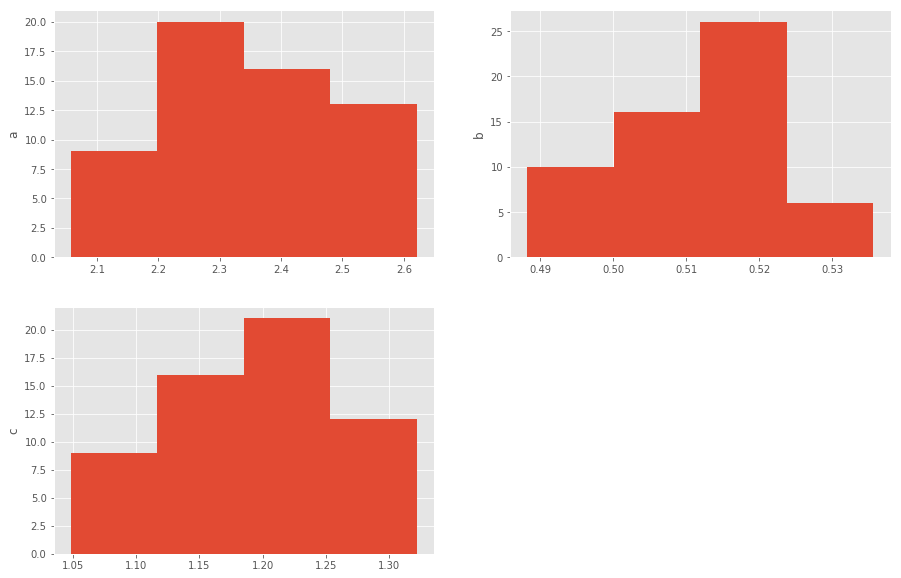

In [50]:
plt.figure(figsize=(15,10))

labels = ['a','b','c']
for i in range(3):
    plt.subplot(2,2,i+1)
    plt.hist(sample[:,i],bins=4)
    plt.ylabel(labels[i])
    

In [35]:
a,b,c = np.mean(sample[:,0]),np.mean(sample[:,1]),np.mean(sample[:,2])

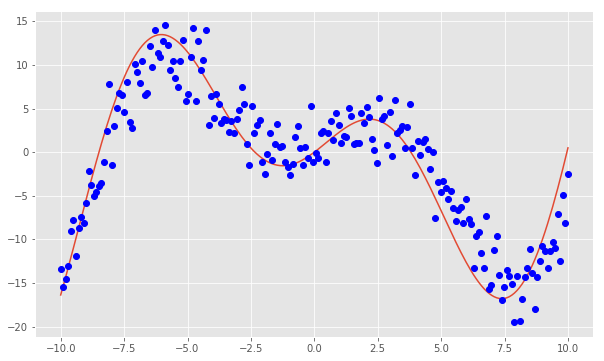

In [36]:
y_model = a*x_values*np.sin(b*x_values + c)

plt.figure(figsize=(10,6))
plt.plot(x_values,y_model)
plt.plot(x_values,y_values,'o',color='blue')

In [37]:
a,b,c

(2.3510949432846107, 0.5108154799300906, 1.1960132045179828)

In [ ]:
nest = 10000
keep = np.zeros((nest,ndim))
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   


logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0
